This notebook presents the semi-physical model of the L1 laser.

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

# Motivation
The goal of this project is to maximise second-harmonic efficiency. However, since it is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.
This knowledge about the actual physical process is presented in the following Figure. 

![](img/semi-physical_model.svg)

# Description

## Stretcher
A signal of the Eletric field represented in the frequency domain, $E(\nu)$, enters the system from the left, where a phase produced by the **Stretcher** is super-imposed to it. The outcome of said superposition is a new frequency representation the very same electric field, in particular:  

$$ y_1(\nu) = E(\nu) \cdot e^{i \varphi_{stretcher}}$$

The phase $\varphi_{stretcher}$ is obtained with a stretcher and it can be modelled using the following equation (which is obtained as a Taylor Expansion of the phase):

$$
\varphi_{stretcher} = \varphi_{stretcher}(GDD, TOD, FOD; \nu, \nu_0) = \frac12 GDD \big(2\pi (\nu - \nu_0)\big)^2 +
            \frac 16 TOD  \big(2\pi (\nu - \nu_0)\big)^3 + \frac 1{24} FOD \big(2\pi(\nu - \nu_0)\big)^4 $$

With $\nu$ being the considered frequencies and $\nu_0$ being the central carrier frequency (corresponding to the average between the half-max frequencies). 

As it is possible to see from the above Figure, even if the control quantities are not exactly $GDD, TOD$ and $FOD$, the actual control quantities are strictly related to these values. In particular, the actual *control* quantities $d_2, d_3$ and $d_4$ are linked to $GDD, TOD$ and $FOD$ via the following system of linear equations: 

$$
\begin{pmatrix}
-\frac{2 \pi c}{\lambda_0^2} & 0 & 0 \\
\frac{4 \pi c}{\lambda_0^3} & \big(\frac{2 \pi c}{\lambda_0^2}\big)^2 & 0 \\
-\frac{12 \pi c}{\lambda_0^4} & \frac{-24 (\pi c)^2}{\lambda_0^5} & -\big(\frac{2 \pi c}{\lambda_0^2}\big)^3
\end{pmatrix}
\cdot
\begin{pmatrix}
GDD \\
TOD \\
FOD
\end{pmatrix} 
= 
\begin{pmatrix}
d_2 \\
d_3 \\
d_4
\end{pmatrix} 
$$

In our implementation of the code, this system is clearly solved using regular forward substitution. 

## DIRA 
Once the controlled phase is super-imposed to the incoming electric field, $y_1(\nu)$ is then propagated through the DIRA block, in which a non-linear phase is accumulated by the signal. This non-linear phase can be modelled (in time only) as: 

$$\varphi_{non\ linear}(t; B) \approx \frac{B}{\max(I(t))} I(t) $$

with $I(t)$ being the intensity (in the time domain) and $B$ being the B-integral, a precise measure of non-linearity whose interpretation falls beyond the scopes of this analysis. However, it is important to note how $B$ has to be considered an hyperparameter of the whole system, i.e. a *non-controlled* quantity which is anyway influencing the dynamics of the system themselves. 
Since this non-linear phase is defined in time-only, its superposition to the incoming $y_1(\nu)$ must take place in the time domain, therefore the DIRA-block can actually be modelled by the following steps: 

1. $y_1(t) \leftarrow $ `ifft`$(y_1(\nu))$; $I(t) \leftarrow y_1(t)^2$

2. $\varphi_{non\ linear}(t; B) \leftarrow \frac{B}{\max(I(t))} I(t)$; $B \approx 2$

3. $y_2(t) \leftarrow y_1(t) \cdot e^{i \varphi_{non\ linear}}(t; B)$

4. $y_2(\nu) \leftarrow$ `fft`$(y_2(t))$

With `fft` and `ifft` being, of course, the Fast Fourier Transform and its inverse. 

## Compressor
Once the non-linear phase has been super-imposed, the signal travels through a compressor, that can be modelled as a block super-imposing once again a *linear* phase. Such linear phase is represented by: 

$$
\varphi_{compressor} = \varphi_{compressor}(\alpha_{GDD}, \alpha_{TOD}, \alpha_{FOD}, \nu, \nu_0) = \frac12 \alpha_{GDD} \big(2\pi (\nu - \nu_0)\big)^2 +
            \frac 16 \alpha_{TOD}  \big(2\pi (\nu - \nu_0)\big)^3 + \frac 1{24} \alpha_{FOD} \big(2\pi(\nu - \nu_0)\big)^4 $$
            
As it is possible to see the phase clearly depends on some parameters, namely $(\alpha_{GDD}, \alpha_{TOD}, \alpha_{FOD})$. These should be considered as a parametrization of the whole system, i.e. as hyperparameters and, therefore *non-controlled* quantities, exactly as $B$. 

The super-imposition of the compressor phase can be modelled with the following equation:

$$y_3(\nu) = y_2(\nu) \cdot e^{i \varphi_{compressor}}$$

## FROG
In this first implementation of the model, once $y_3(\nu)$ is available it is represented in the time-domain (mainly leveraging Fourier transform). The time-based representation of the pulse is then compared with the Transform Limited pulse, which is the one obtained super-imposing a zero-phase to the initial spectral electric field. 

Once this is done, conceptually, a Feedback Signal is propagated backwards to adjust the control parameters so as to minimise such a difference. 

In [1]:
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../")

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c

from utils.LaserModel import LaserModel
data_path = "../data/L1_pump_spectrum.csv"

## Data Pre-Processing
Here the data are converted to a format which is compatible with the specifics of the simulated laser. In particular: 
1. Wavelenght in converted in frequency

2. Negative values of intensity are mapped to zero, as they are very likely to be due to measurement issues

In [2]:
# read the data
df = pd.read_csv(data_path, header = None)
df.columns = ["Wavelength (nm)", "Intensity"]
# converting Wavelength in Frequency
df["Frequency (THz)"] = df["Wavelength (nm)"].apply(lambda wavelenght: 1e-12 * (c/(wavelenght * 1e-9)))
# clipping everything that is negative
df["Intensity"] = df["Intensity"].apply(lambda intensity: np.clip(intensity, a_min = 0, a_max = None))
# the observations must be returned for increasing values of frequency
df = df.sort_values(by = "Frequency (THz)")

frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
field = np.sqrt(intensity)

# Pre-processing activity
The data considered undergo an initial phase a pre-processing that consists in a process of: 
1. **Data Cleaning - Spectrum Cleaning**: Only those frequencies for which non null values of the electric field are detected have to be considered in the analysis. However, before the instruments start detecting an actual field, measurement errors make the perceived field non null. To restrict the analysis to the portion of the spectrum which is made only by actual non-null frequencies a part of the signal is cut off. 

2. **Data Cleaning - Signal Augmentation**: The measurement instruments do not register the intensity at equidistant frequencies. This can worsen `fft` algorithm performance, therefore we use a simple Univariate Spline to interpolate the input data and a `linspace` to reconstruct the signal at equidistant points. Moreover, the signal is reconstructed at more points, effectively augmenting the quantity of available data

Moreover, the central carrier frequency is also obtained using the correspoding method presented in the `physics.py` script. 

In [3]:
from utils.physics import *

cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(1e4)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)


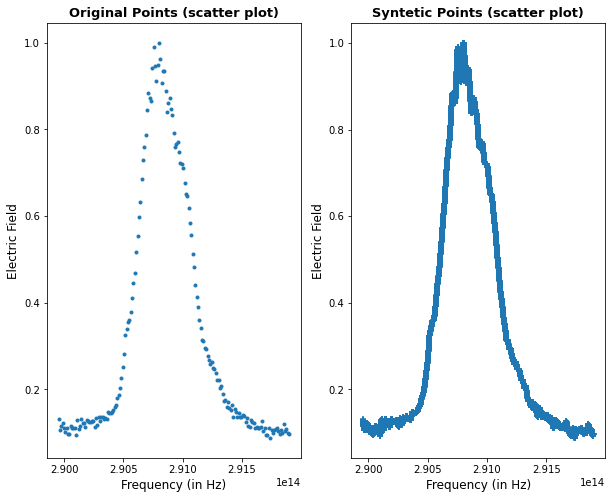

In [4]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,8))

ax[0].set_title("Original Points (scatter plot)", fontweight = "bold", fontsize = 13)
ax[0].scatter(frequency_clean, field_clean, marker = ".")
ax[0].set_xlabel("Frequency (in Hz)", fontsize = 12)
ax[0].set_ylabel("Electric Field", fontsize = 12)

ax[1].set_title("Syntetic Points (scatter plot)", fontweight = "bold", fontsize = 13)
ax[1].scatter(frequency_clean_aug, field_clean_aug, marker = "+")
ax[1].set_xlabel("Frequency (in Hz)", fontsize = 12)
ax[1].set_ylabel("Electric Field", fontsize = 12)

plt.show()

In [5]:
print("Initial number of data points: ", len(frequency))
print("Total number of data points: ", len(frequency_clean_aug))

Initial number of data points:  3648
Total number of data points:  10000


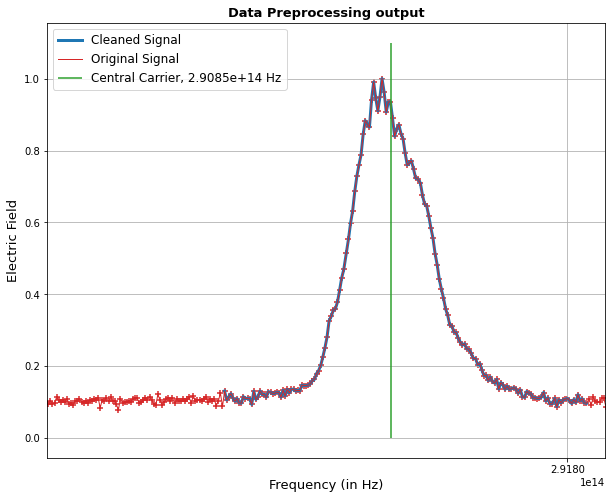

In [6]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(frequency_clean, field_clean, lw = 3, color = "tab:blue", label = "Cleaned Signal")
ax.scatter(frequency * 10**12, field, marker = "+", c = "tab:red")
ax.plot(frequency * 10**12, field, lw = 1, c = "tab:red", label = "Original Signal")

ax.vlines(x = central_carrier,
          ymin = 0,
          ymax=1.1 * field_clean.max(),
          colors = "tab:green",
          label = "Central Carrier, {:.4e} Hz".format(central_carrier))

ax.set_xlabel("Frequency (in Hz)", fontdict = {"fontsize":13})
ax.set_ylabel("Electric Field", fontdict = {"fontsize":13})
ax.set_title("Data Preprocessing output", fontdict = {"fontsize":13, "fontweight": "bold"})

ax.set_xticks(ticks = frequency[::250]*10**12)
ax.set_xlim(left = 289 * 1e12, right = 292 * 1e12)
ax.grid()

ax.legend(fontsize = 12)

plt.show()

# Model Check

In [7]:
frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
#intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())

lm = LaserModel(frequency = frequency, 
                intensity = intensity, 
                cutoff = (289.95, 291.91), 
                num_points_padding=int(6e4),
                B = 0,
                compressor_params = np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
)

In [8]:
# evaluating inference time (time for one forward pass)
import time

control = np.zeros(shape = (3,))
start_time = time.time()
_, _ = lm.forward_pass(control = control)
print("Pass time equals to {:.4e} seconds".format(time.time()-start_time))

Pass time equals to 9.8660e-03 seconds


After having observed that the latence of the semi-physical model is around 0.007 seconds, it is possible to test its validity. A first sanity check is to see if the stretcher-compressor relationship has been correctly modeled. 

In particular, having that: 

$$\alpha_{GDD}, \alpha_{TOD}, \alpha_{FOD} = \big (267.422 \cdot 10^{-24} [s^2], -2.384 \cdot 10^{-36} [s^3], 9.54893 \cdot 10^{-50} [s^4] \big) $$

If one assumes that $B = 0$ then no linear phase should be accumulated in the DIRA. This can be checked imposing a control on the stretcher equal to: 

$$
(GDD, TOD, FOD) = - (\alpha_{GDD}, \alpha_{TOD}, \alpha_{FOD}) \implies \varphi_{stretcher} = -\varphi_{compressor}
$$

In such a case, if and only if $B = 0$, it is clear that: 

$$
y_3 (\nu) = E(\nu) \cdot e^{i \cdot \varphi_{stretcher}} \cdot e^{i \cdot \varphi_{compressor}} = E(\nu) \cdot e^{i\cdot (-\varphi_{compressor} + \varphi_{compressor})} = E(\nu)$$

Which clearly corresponds to $E(\nu)$ when zero phase is imposed on it.
Testing this condition is a first step towards validating the semi-physical model just presented.

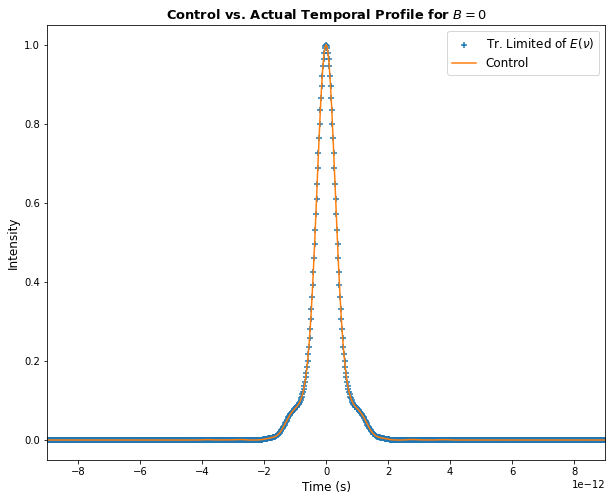

In [9]:
optimal_control = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
# since the model is controlled in d2, d3 and d4 these three values must be obtained inverting the control
# translation
control = lm.translate_control(optimal_control, verse = "to_disp")
# temporal profile - control
time_control, profile_control = lm.forward_pass(control)
# temporal profile - original
frequency, field = lm.spit_center()
time, profile_TL = temporal_profile(frequency, field, phase = np.zeros_like(field), npoints_pad = lm.pad_points)

fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(time, profile_TL, label = r"Tr. Limited of $E(\nu)$", marker = "+", s = 40)
ax.plot(time_control, profile_control, label = "Control", color = "tab:orange")

ax.legend(fontsize = 12)
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Intensity", fontsize = 12)
ax.set_title(r"Control vs. Actual Temporal Profile for $B = 0$", fontsize = 13, fontweight = "bold")

ax.set_xlim(left = -0.9e-11, right = 0.9e-11)
plt.show()

Moreover, to furthermore verify that the semi-physical model is actually able to capture information related to the non-linear phase considered, it is possible to see what happens with various levels of B to the signal when the "optimal" control (the one vanishing the compressor's phase using the stretcher) in the simple-linear case is performed.

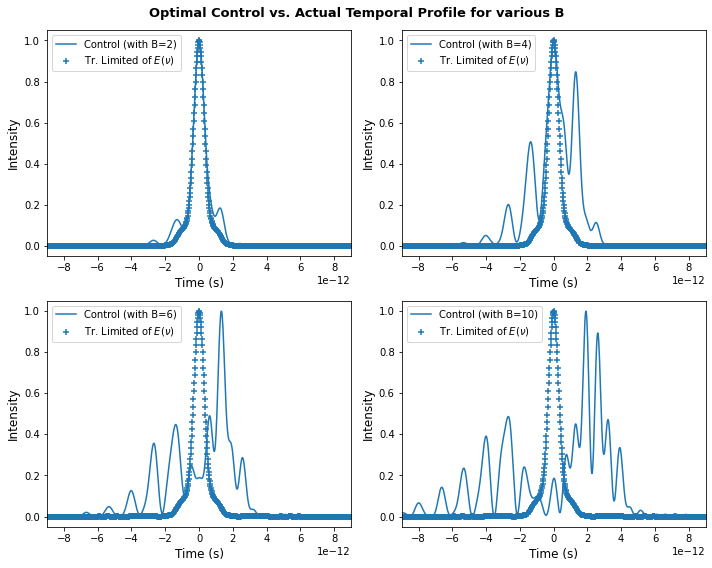

In [10]:
B_list = [2, 4, 6, 10]
nrows, ncols = 2, 2

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (10,8))

frequency, field = lm.spit_center()
time, profile_TL = temporal_profile(frequency, field, phase = np.zeros_like(field), npoints_pad = lm.pad_points)

c = 0
for idx in range(len(B_list)):
    B = B_list[idx]
    frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
    
    lm = LaserModel(frequency = frequency, 
                    intensity = intensity, 
                    cutoff = (289.95, 291.91), 
                    num_points_padding=int(6e4),
                    B = B,
                    compressor_params = np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
    )
    
    lm.preprocessing()
    # temporal profile - control
    time_control, profile_control = lm.forward_pass(control)
    
    current = ax[c//2, c%2]
    
    current.plot(time_control, profile_control, label = f"Control (with B={B})")
    current.scatter(time, profile_TL, label = r"Tr. Limited of $E(\nu)$", marker = "+", s = 40)

    current.legend(fontsize = 10, loc = "upper left")
    current.set_xlabel("Time (s)", fontsize = 12)
    current.set_ylabel("Intensity", fontsize = 12)

    current.set_xlim(left = -0.9e-11, right = 0.9e-11)
    c += 1

fig.suptitle(r"Optimal Control vs. Actual Temporal Profile for various B", fontsize = 13, fontweight = "bold")
fig.tight_layout()
plt.show()